In [383]:
import os
import collections
import torch
import numpy as np
from torch.utils import data
from torch.autograd import Variable
from PIL import Image

def recursive_glob(rootdir='.', suffix=''):
    """Performs recursive glob with given suffix and rootdir 
        :param rootdir is the root directory
        :param suffix is the suffix to be searched
    """
    return [os.path.join(looproot, filename)
        for looproot, _, filenames in os.walk(rootdir)
        for filename in filenames if filename.endswith(suffix)]

class NYUDv2Loader(data.Dataset):
    def __init__(self, root, split="training", is_transform=False, img_size=(480, 640), img_norm=False):
        self.root = root
        self.is_transform = is_transform
        self.n_classes = 14
        self.img_norm = img_norm
        self.img_size = img_size if isinstance(img_size, tuple) else (img_size, img_size)
        self.color_mean = np.array([104.00699, 116.66877, 122.67892])
        self.depth_mean = 0
        self.color_max = 255
        self.depth_max = 5000
        self.color_files = collections.defaultdict(list)
        self.depth_files = collections.defaultdict(list)
        self.label_files = collections.defaultdict(list)
        self.cmap = self.color_map(normalized=False)

        split_map = {"training": 'train', "val": 'test',}
        self.split = split_map[split]

        for split in ["train", "test"]:
            file_list =  sorted(recursive_glob(rootdir=self.root + split +'/color/', suffix='png'))
            self.color_files[split] = file_list
        
        for split in ["train", "test"]:
            file_list =  sorted(recursive_glob(rootdir=self.root + split +'/depth/', suffix='png'))
            self.depth_files[split] = file_list    
        
        for split in ["train", "test"]:
            file_list =  sorted(recursive_glob(rootdir=self.root + split +'/label/', suffix='png'))
            self.label_files[split] = file_list


    def __len__(self):
        return len(self.color_files[self.split])


    def __getitem__(self, index):
        color_path = self.color_files[self.split][index].rstrip()
        depth_path = self.depth_files[self.split][index].rstrip()
        label_path = self.label_files[self.split][index].rstrip()

        color_img = Image.open(color_path)    
        depth_img = Image.open(depth_path)    
        label_img = Image.open(label_path)    
        
        if self.is_transform:
            color_img, depth_img, label_img = self.transform(color_img, depth_img, label_img)
        
        return np.asarray(color_img), np.asarray(depth_img), np.asarray(label_img)


    def transform(self, color_img, depth_img, label_img):
        color_img = color_img.resize((self.img_size[1], self.img_size[0]), Image.ANTIALIAS)
        color_img = np.asarray(color_img)
        color_img = color_img[:, :, ::-1] # RGB -> BGR
        color_img = color_img.astype(np.float64)
        if self.img_norm:
            color_img -= self.color_mean
            color_img = color_img.astype(float) / self.color_max
        color_img = color_img.transpose(2, 0, 1)        # NHWC -> NCHW

        depth_img = depth_img.resize((self.img_size[1], self.img_size[0]), Image.ANTIALIAS)
        depth_img = np.asarray(depth_img)
        depth_img = depth_img.astype(np.float64)
        depth_img = depth_img[np.newaxis,:]
        if self.img_norm:
            depth_img -= self.depth_mean
            depth_img = depth_img.astype(float) / self.depth_max
        
        classes = np.unique(label_img)
        label_img = label_img.resize((self.img_size[1], self.img_size[0]), Image.NEAREST)
        label_img = np.asarray(label_img)
        label_img = label_img[np.newaxis,:]
        assert(np.all(classes == np.unique(label_img)))

#         color_img = torch.from_numpy(color_img).float()
#         depth_img = torch.from_numpy(depth_img).float()
#         label_img = torch.from_numpy(label_img).long()
        
        return color_img, depth_img, label_img


    def color_map(self, N=256, normalized=False):
        """
        Return Color Map in PASCAL VOC format
        """

        def bitget(byteval, idx):
            return ((byteval & (1 << idx)) != 0)

        dtype = 'float32' if normalized else 'uint8'
        cmap = np.zeros((N, 3), dtype=dtype)
        for i in range(N):
            r = g = b = 0
            c = i
            for j in range(8):
                r = r | (bitget(c, 0) << 7-j)
                g = g | (bitget(c, 1) << 7-j)
                b = b | (bitget(c, 2) << 7-j)
                c = c >> 3

            cmap[i] = np.array([r, g, b])

        cmap = cmap/255.0 if normalized else cmap
        return cmap


    def decode_segmap(self, temp):
        r = temp.copy()
        g = temp.copy()
        b = temp.copy()
        for l in range(0, self.n_classes):
            r[temp == l] = self.cmap[l,0]
            g[temp == l] = self.cmap[l,1]
            b[temp == l] = self.cmap[l,2]

        rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
        rgb[:, :, 0] = r / 255.0
        rgb[:, :, 1] = g / 255.0
        rgb[:, :, 2] = b / 255.0
        return rgb

In [384]:
t_loader = NYUDv2Loader('/home/dongwonshin/Desktop/Datasets/NYUDv2/', split='training', 
                        is_transform=True, img_norm=True, img_size=(240,320))
v_loader = NYUDv2Loader('/home/dongwonshin/Desktop/Datasets/NYUDv2/', split='val', 
                        is_transform=True, img_norm=True, img_size=(240,320))

train_loader = data.DataLoader(t_loader, batch_size=4, num_workers=16, shuffle=True)
val_loader = data.DataLoader(v_loader, batch_size=4, num_workers=16)

In [385]:
for color, depth, label in train_loader:
    print(color.shape)
    print(depth.shape)
    print(label.shape)
    break;

torch.Size([4, 3, 240, 320])
torch.Size([4, 1, 240, 320])
torch.Size([4, 1, 240, 320])


In [386]:
color[0]

tensor([[[ 0.5921,  0.5921,  0.5921,  ...,  0.5921,  0.5921,  0.5921],
         [ 0.5921,  0.5921,  0.5921,  ...,  0.5921,  0.5921,  0.5921],
         [ 0.5921,  0.5843,  0.5882,  ...,  0.5921,  0.5921,  0.5921],
         ...,
         [ 0.5882,  0.5921,  0.5647,  ...,  0.5921,  0.5804,  0.5921],
         [ 0.5921,  0.5921,  0.5921,  ...,  0.5921,  0.5921,  0.5921],
         [ 0.5921,  0.5921,  0.5921,  ...,  0.5921,  0.5921,  0.5921]],

        [[ 0.5425,  0.5425,  0.5425,  ...,  0.5425,  0.5425,  0.5425],
         [ 0.5425,  0.5425,  0.5425,  ...,  0.5425,  0.5425,  0.5425],
         [ 0.5425,  0.5346,  0.5386,  ...,  0.5425,  0.5425,  0.5425],
         ...,
         [ 0.5386,  0.5425,  0.5189,  ...,  0.5425,  0.5307,  0.5425],
         [ 0.5425,  0.5425,  0.5425,  ...,  0.5425,  0.5425,  0.5425],
         [ 0.5425,  0.5425,  0.5425,  ...,  0.5425,  0.5425,  0.5425]],

        [[ 0.5189,  0.5189,  0.5189,  ...,  0.5189,  0.5189,  0.5189],
         [ 0.5189,  0.5189,  0.5189,  ...,  0

In [387]:
depth[0]

tensor([[[ 0.3488,  0.3488,  0.3492,  ...,  0.6260,  0.6260,  0.6260],
         [ 0.3488,  0.3488,  0.3490,  ...,  0.6260,  0.6260,  0.6260],
         [ 0.3484,  0.3484,  0.3488,  ...,  0.6260,  0.6260,  0.6260],
         ...,
         [ 0.3154,  0.3154,  0.3150,  ...,  0.3654,  0.3622,  0.3628],
         [ 0.3156,  0.3156,  0.3160,  ...,  0.3618,  0.3626,  0.3626],
         [ 0.3158,  0.3158,  0.3160,  ...,  0.3620,  0.3624,  0.3624]]], dtype=torch.float64)

In [388]:
label

tensor([[[[  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          ...,
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0]]],


        [[[  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          ...,
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0]]],


        [[[  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          ...,
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0]]],


        [[[  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,

# visualization

In [408]:
%matplotlib inline
import matplotlib.pyplot as plt

def visualize_color_image_from_dataloader(color_img, unnormalized=False):
    color_img = np.transpose(color_img, [1,2,0])
    color_img = color_img[:, :, ::-1] # RGB -> BGR
    if unnormalized == True:
        color_img = Image.fromarray(np.uint8(color_img*255))
    else:
        color_img = Image.fromarray(np.uint8(color_img))
    plt.imshow(color_img)

In [400]:
def visualize_depth_image_from_dataloader(depth_img, unnormalized=False):
    depth_img = np.transpose(depth_img, [1,2,0])
    if unnormalized == True:
        depth_img = Image.fromarray(np.uint8(depth_img[:,:,0]*255))
    else: 
        depth_img = Image.fromarray(np.uint8(depth_img[:,:,0]/5000*255))
    plt.imshow(depth_img)

In [371]:
def color_map(N=256, normalized=False):
    """
    Return Color Map in PASCAL VOC format
    """

    def bitget(byteval, idx):
        return ((byteval & (1 << idx)) != 0)

    dtype = 'float32' if normalized else 'uint8'
    cmap = np.zeros((N, 3), dtype=dtype)
    for i in range(N):
        r = g = b = 0
        c = i
        for j in range(8):
            r = r | (bitget(c, 0) << 7-j)
            g = g | (bitget(c, 1) << 7-j)
            b = b | (bitget(c, 2) << 7-j)
            c = c >> 3

        cmap[i] = np.array([r, g, b])

    cmap = cmap/255.0 if normalized else cmap
    return cmap

n_classes = 14
cmap = color_map()

def decode_segmap(label_img):
    r = label_img.copy()
    g = label_img.copy()
    b = label_img.copy()
    for l in range(0, n_classes):
        r[label_img == l] = cmap[l,0]
        g[label_img == l] = cmap[l,1]
        b[label_img == l] = cmap[l,2]

    rgb = np.zeros((label_img.shape[0], label_img.shape[1], 3))
    rgb[:, :, 0] = r 
    rgb[:, :, 1] = g 
    rgb[:, :, 2] = b 
    return rgb

def visualize_label_image_from_dataloader(label_img):
    label_img = np.transpose(label_img, [1,2,0])
    label_img = np.asarray(label_img)
    color_labeld_img = decode_segmap(label_img[:,:,0])
    color_labeld_img = Image.fromarray(np.uint8(color_labeld_img))
    plt.imshow(color_labeld_img)

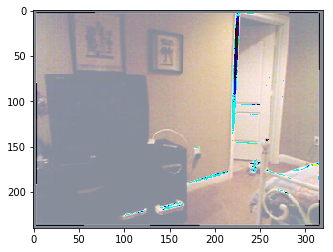

In [411]:
visualize_color_image_from_dataloader(color[0].numpy(), unnormalized=True)

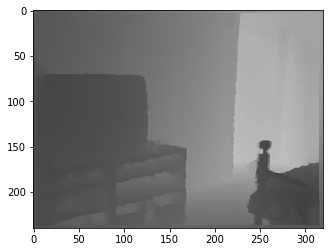

In [405]:
visualize_depth_image_from_dataloader(depth[0].numpy(), unnormalized=True)

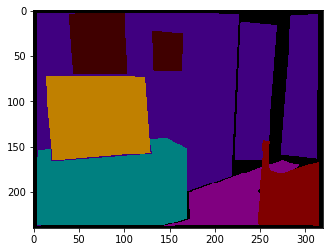

In [391]:
visualize_label_image_from_dataloader(label[0].numpy())

In [ ]:
import sys
sys.path.insert(0, '../')
sys.path.insert(0, '../dataloaders')

import numpy as np
import torch
from torch.autograd import Variable
from FuseNet import FuseNet, CrossEntropy2d
from Solver_FuseNet import Solver_SS
import torch.nn.functional as F
from utils.data_utils_class import get_data

import time

import h5py
import scipy.io 
import os

from NYUDv2Loader import *

In [ ]:
############################################################################
#                                TRAIN                                     #
############################################################################

resume = False
dset_type = 'NYU'
t_loader = NYUDv2Loader('/home/dongwonshin/Desktop/Datasets/NYUDv2/', split='training', 
                        is_transform=True, img_norm=True, img_size=(240,320))
v_loader = NYUDv2Loader('/home/dongwonshin/Desktop/Datasets/NYUDv2/', split='val', 
                        is_transform=True, img_norm=True, img_size=(240,320))

train_loader = data.DataLoader(t_loader, batch_size=4, num_workers=16, shuffle=True)
val_loader = data.DataLoader(v_loader, batch_size=4, num_workers=16)

In [ ]:
print ("[PROGRESS] %s dataset retrieved"  %(dset_type))

model = FuseNet(14).cuda()

solver = Solver_SS(optim_args={"lr":5e-3, "weight_decay": 0.0005}, loss_func=CrossEntropy2d)
solver.train(model, dset_type, train_loader, val_loader, resume=False, log_nth=5)